<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Analyse-chopping" data-toc-modified-id="Analyse-chopping-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Analyse chopping</a></span></li></ul></div>

In [67]:
import sys
sys.path.append('..')
sys.path.append('./qaoa')

In [80]:
import pyrofiler as prof
from multiprocessing.dummy import Pool
import utils_qaoa as qaoa
import utils
import numpy as np
import qtree
import copy
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Analyse chopping


In [41]:
chop_pts = 3
def get_chop_idxs(graph, peo, cost, nghs):
    drop_idx = get_chop_dn_drop(nghs)
    min_idx = np.argmin(cost[0][:drop_idx])
    before_min = min_idx - (drop_idx-min_idx)
    on_plato = 2 * min_idx // 3
        
    return min_idx, drop_idx, drop_idx+5

def _cost_before_chop(idxs, cost):
    mems, floats = cost
    before_mem = [max(mems[:i]) for i in idxs]
    return before_mem

def get_chop_dn_drop(nghs):
    nghs = np.array(nghs)
    dn = nghs[1:] - nghs[:-1]
    neg_idx = [i for i, n in enumerate(dn) if n<0]
    pos_idx = [i for i, n in enumerate(dn) if n>0]
    drop_idx = neg_idx[0]
    pos_idx.reverse()
    before_drop = [i for i in pos_idx if i<drop_idx]
    return before_drop[0] - 1




In [42]:
def contract_by_peo(old_graph, peo):
    graph = copy.deepcopy(old_graph)
    for n in peo:
        qtree.graph_model.eliminate_node(graph, n)
    return graph

In [43]:
sizes = [12, 13]

tasks = [qaoa.get_test_expr_graph(s, 1) for s in sizes]
graphs =     [g for g, _ in tasks]
qbit_sizes = [N for _, N in tasks]

2020-03-11 19:15:06,497- INFO•	Generated graph with 688 nodes and 1498 edges
2020-03-11 19:15:06,547- INFO•	Generated graph with 742 nodes and 1617 edges


In [44]:
print('Qubit sizes', qbit_sizes)
pool = Pool(processes=1)

Qubit sizes [91, 98]


In [45]:
def n_peo(graph):
    return utils.get_locale_peo(graph, utils.n_neighbors)
peos_n = pool.map(n_peo, graphs)
peos, nghs = zip(*peos_n)

In [46]:
_get_cost = lambda x: qaoa.cost_graph_peo(*x)

with prof.timing('Get full costs naive'):
    costs = pool.map(_get_cost, zip(graphs, peos))

KeyboardInterrupt: 

In [47]:
chopped_g = [
    contract_by_peo(g, peo[:_idx]) 
    for g, peo, cost, ng in tqdm( zip(graphs, peos, costs, nghs) )
    for _idx in get_chop_idxs(g, peo, cost, ng)
]

costs_before_chop = [
    mem
    for g, peo, cost, ng in tqdm( zip(graphs, peos, costs, nghs) )
    for mem in _cost_before_chop(get_chop_idxs(g, peo, cost, ng), cost)
]





0it [00:00, ?it/s]



1it [00:00,  4.77it/s]



2it [00:00,  4.99it/s]




2it [00:00, 760.46it/s]A


In [ ]:
print('contracted graphs', [g.number_of_nodes() for g in chopped_g])

print('costs before chop', costs_before_chop)

In [48]:
par_vars = [0,1,2,5, 7, 12]

parallelized_g = [
    g
    for graph in chopped_g
    for parvar in par_vars
    for  _, g in [qtree.graph_model.split_graph_by_metric(graph, n_var_parallel=parvar)]
]

2020-03-11 19:15:36,794- INFO•	Removed indices by parallelization:
[]
2020-03-11 19:15:36,798- INFO•	Removed 0 variables
2020-03-11 19:15:36,833- INFO•	Removed indices by parallelization:
[203]
2020-03-11 19:15:36,836- INFO•	Removed 1 variables
2020-03-11 19:15:36,854- INFO•	Removed indices by parallelization:
[203, 205]
2020-03-11 19:15:36,856- INFO•	Removed 2 variables
2020-03-11 19:15:36,871- INFO•	Removed indices by parallelization:
[203, 205, 221, 189, 193]
2020-03-11 19:15:36,872- INFO•	Removed 5 variables
2020-03-11 19:15:36,885- INFO•	Removed indices by parallelization:
[203, 205, 221, 189, 193, 215, 217]
2020-03-11 19:15:36,886- INFO•	Removed 7 variables
2020-03-11 19:15:36,899- INFO•	Removed indices by parallelization:
[203, 205, 221, 189, 193, 215, 217, 219, 223, 227, 229, 231]
2020-03-11 19:15:36,900- INFO•	Removed 12 variables
2020-03-11 19:15:36,908- INFO•	Removed indices by parallelization:
[]
2020-03-11 19:15:36,914- INFO•	Removed 0 variables
2020-03-11 19:15:36,934- IN

In [49]:
print('parallelised graphs', [g.number_of_nodes() for g in parallelized_g])

parallelised graphs [78, 77, 76, 73, 71, 66, 45, 44, 43, 40, 38, 33, 40, 39, 38, 35, 33, 28, 85, 84, 83, 80, 78, 73, 45, 44, 43, 40, 38, 33, 40, 39, 38, 35, 33, 28]


In [56]:
def n_peo(graph):
    return utils.get_locale_peo(graph, utils.n_neighbors)
_pg_peos = tqdm(list(zip(parallelized_g, peos_par)))
with prof.timing('peos chopped'):
    peos_par_n = pool.map(n_peo, tqdm(parallelized_g))
peos_par, nghs_par = zip(*peos_par_n)






  0%|          | 0/36 [00:00<?, ?it/s]




100%|██████████| 36/36 [00:00<00:00, 88404.53it/s]


peos chopped : 0.6613430976867676


In [54]:
def get_qbb_peo(graph):
    try:
        peo, tw = qtree.graph_model.get_peo(graph)
        fail = False
    except:
        print('QBB fail, nodes count:', graph.number_of_nodes())
        peo, nghs = utils.get_locale_peo(graph, utils.n_neighbors)
        fail = True
    return peo, fail

In [ ]:
peos_par = [ get_qbb_peo(g) for g in tqdm( parallelized_g ) ]
peos_par, fails_qbb = zip(*peos_par)

In [ ]:
tqdm._instances.clear()

In [57]:
_pg_peos = tqdm(list(zip(parallelized_g, peos_par)))
with prof.timing('Costs chopped'):
    costs_all = pool.map(_get_cost, _pg_peos)







100%|██████████| 36/36 [00:00<00:00, 3037.09it/s]A


Costs chopped : 2.955335855484009


In [72]:
experiment_name = 'small_chops_test'

In [73]:
mems = [max(m) for m,_ in costs_all ]

In [74]:
_data = np.array(mems).reshape(len(sizes), chop_pts, len(par_vars)) 

print(_data)
np.save(f'cached_data/{experiment_name}',_data)

[[[34842 21304  9502  8734  9118  3996]
  [34842 34842 10272  8726  3804  1316]
  [34842  9502  3804  3804  3804  3804]]

 [[18986 30242 15896 15896  8734  9118]
  [18986 12198 15896  8726  8726  2194]
  [18986 34842 17432  3506  2980  1296]]]


In [78]:
def trid_plot(x, y, labels, dimspec=(0,1,2)): 
    y = y.transpose(dimspec)
    plot_cnt = y.shape[0]
    line_cnt = y.shape[1]
    def _label_of(dim, idx):
        return labels[dim] + ' ' + str(x[dim][idx])
    
    fig, axs = plt.subplots(1, plot_cnt, sharey=True, figsize=(15,4))
    try:
        iter(axs)
    except TypeError:
        axs = [axs]
    for i, ax in enumerate(axs):
        plt.sca(ax)
        plt.title(_label_of(0, i))
        for j in range(line_cnt):
            plt.plot(x[2], y[i,j], label=_label_of(1, j))
            plt.xlabel(labels[2])
            plt.yscale('log')
            plt.minorticks_on()
            plt.legend()

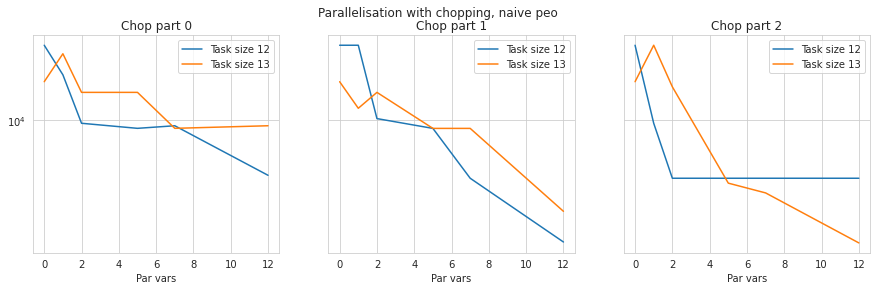

In [81]:
xs = [np.arange(chop_pts), sizes, par_vars]
trid_plot(xs, _data, ['Chop part', 'Task size', 'Par vars'],(1,0,2))
plt.suptitle('Parallelisation with chopping, naive peo')
plt.savefig(f'figures/chop_analysis__{experiment_name}.pdf')

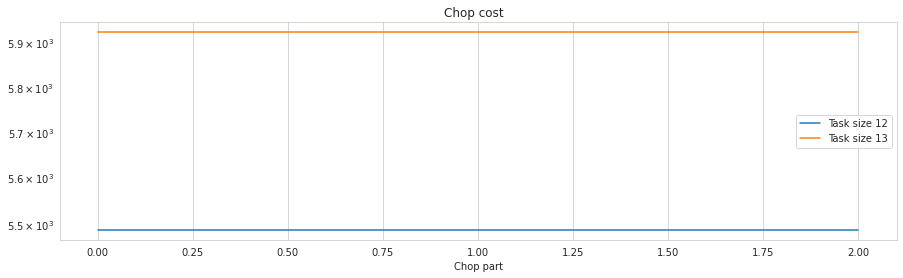

In [83]:
_chopcost = np.array(costs_before_chop).reshape(len(sizes), chop_pts, 1)
trid_plot([' ', sizes, range(chop_pts)], _chopcost, ['Chop cost', 'Task size', 'Chop part'], (2,0,1))


In [84]:
print(_chopcost)

[[[5488]
  [5488]
  [5488]]

 [[5924]
  [5924]
  [5924]]]
